In this repository, we test how good the fixed point caluclation is and is the dynamical system remains stable for this arbitrary recurrent weight matrix.

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import math
from perturbed_organics.spectrum_general import matrix_solution
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
from perturbed_organics.utils.util_funs import dynm_fun
import numpy as np
import os
from matplotlib import colors
from scipy.optimize import fsolve, curve_fit
from scipy import integrate
import warnings

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
cmap = 'viridis'

In [128]:
"""Define the parameters of the ORGaNICs"""
N = 20
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.02,
    'noise_type': 'additive'
}
b0 = 0.5 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
sigma = 0.1
#tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
#tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauA = 2 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 2 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
#Way = torch.ones(N, N)
Way = torch.rand(N, N)

In [138]:
def sample_sparse_matrix(N, c, delta, mu):
    mask = torch.bernoulli(torch.full((N, N), c / N)).triu()
    values = torch.normal(mu, delta, (N, N))
    upper_triangular = values * mask
    #symmetric_matrix = upper_triangular + upper_triangular.T - torch.diag(torch.diag(upper_triangular))
    symmetric_matrix = torch.bernoulli(torch.full((N, N), c / N))*torch.normal(mu, delta, (N, N))
    return symmetric_matrix

In [139]:
mu = 0.0
c = 1.0 * N # sparsity
delta = 0.15

Wyy = torch.eye(N) + sample_sparse_matrix(N, c, delta, mu)
# count the number of non-zero elements
non_zero = torch.sum(Wyy != 0)

print(f'Sparsity of the matrix is {non_zero / N**2:.2f}')

# make the input drive to be ones 
gamma = 0.9
z = torch.ones(N)
# make z to be norm gamma
z = z / torch.norm(z) * gamma

Sparsity of the matrix is 1.00


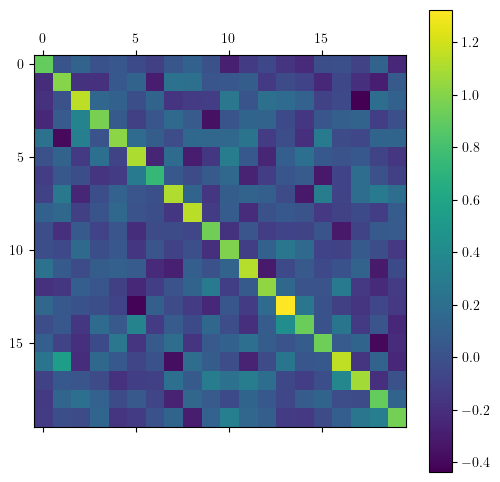

In [140]:
# imshow the matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.matshow(Wyy, cmap=cmap)
fig.colorbar(cax)
plt.show()

In [141]:
num_trials = 1
eigenvals_wyy = torch.zeros((num_trials, N), dtype=torch.complex64)
eigenvals_J = torch.zeros((num_trials, 2 * N), dtype=torch.complex64)
norm_fixed_point_y = torch.zeros((num_trials, N))
norm_fixed_point_a = torch.zeros((num_trials, N))
actual_fixed_point_y = torch.zeros((num_trials, N))
actual_fixed_point_a = torch.zeros((num_trials, N))
bool_stable = torch.zeros(num_trials, dtype=torch.bool)


In [142]:
# Find all the quantities of interest
for i in range(num_trials):
    try :
        # sample a random Wyy matrix
        Wyy = torch.eye(N) + sample_sparse_matrix(N, c, delta, mu)
        eigenvals_wyy[i] = torch.linalg.eigvals(Wyy)

        # find the fixed point of the model
        model = organics.ORGaNICs2Dgeneral(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=True)
        actual_fixed_point_y[i] = model.ss[0:N] # will catch a None type object is not scriptable error here
        actual_fixed_point_a[i] = model.ss[N:2*N]

        # normalization fixed point
        norm_fixed_point_y[i], norm_fixed_point_a[i] = model.analytical_ss()

        # eigenvalues of the jacobian
        eigenvals_J[i] = torch.linalg.eigvals(model.J)

        bool_stable[i] = True

    except Exception as e:
        print(f'Error in trial {i}')
        print(e)
        norm_fixed_point_y[i], norm_fixed_point_a[i] = model.analytical_ss()
        bool_stable[i] = False

In [143]:
bool_stable

tensor([True])

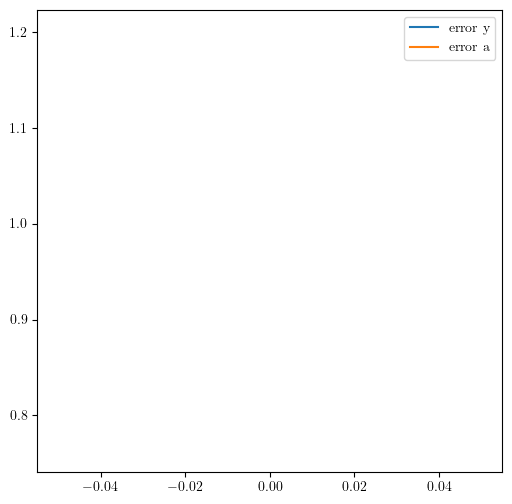

In [144]:
# find the error between the analytical and the actual fixed points
error_y = torch.norm(actual_fixed_point_y - norm_fixed_point_y, dim=1) / torch.norm(norm_fixed_point_y, dim=1)
error_a = torch.norm(actual_fixed_point_a - norm_fixed_point_a, dim=1) / torch.norm(norm_fixed_point_a, dim=1)

# plot them 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(error_y, label='error y')
ax.plot(error_a, label='error a')
ax.legend()
plt.show()


In [145]:
J = model.J

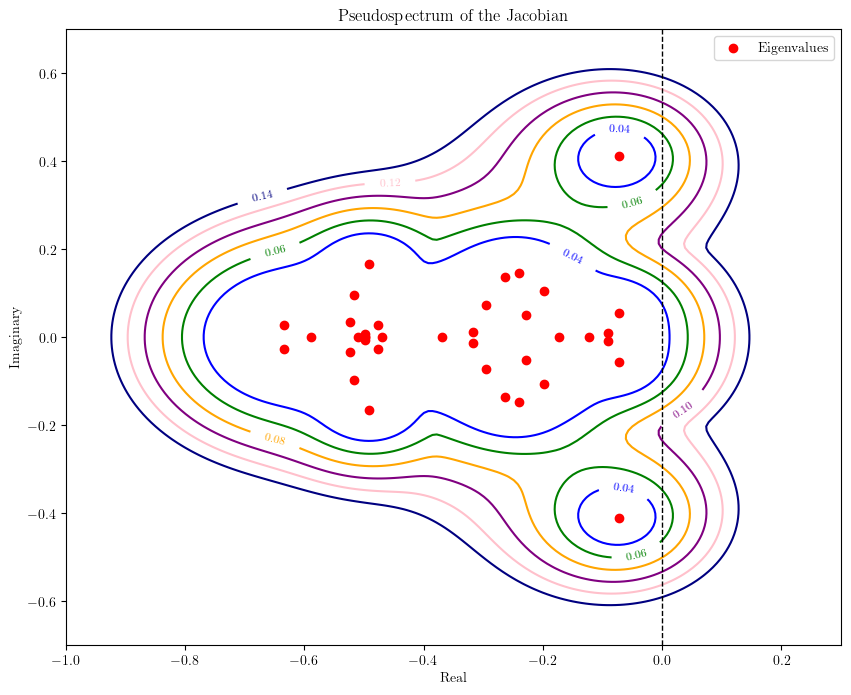

In [151]:
epsilon_values = [0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
contour_colors = ['blue', 'green', 'orange', 'purple', 'pink', 'navy']  # Corresponding colors

grid_size = 300

J_np = J.numpy().astype(np.complex128)
# J_np = torch.rand(10, 10)
    
# Compute eigenvalues of J for plot boundaries
eigs = np.linalg.eigvals(J_np)

# Define grid range for real and imaginary parts based on eigenvalues
real_vals = np.linspace(np.min(np.real(eigs)) - 1, 0.5, grid_size)
imag_vals = np.linspace(np.min(np.imag(eigs)) - 1, np.max(np.imag(eigs)) + 1, grid_size)
real_grid, imag_grid = np.meshgrid(real_vals, imag_vals)

# Prepare tensor for pseudospectrum values
pseudospectra = np.zeros((grid_size, grid_size), dtype=np.float32)

# Calculate pseudospectrum values
for i in range(grid_size):
    for j in range(grid_size):
        z = real_grid[i, j] + 1j * imag_grid[i, j]
        I = torch.eye(J.size(0), dtype=J.dtype)
        M = J - (z.real * I) - (z.imag * I * 1j)  # Avoid complex type in PyTorch
        M_np = M.numpy().astype(np.complex128)
        
        # Compute the smallest singular value using SVD
        _, s, _ = np.linalg.svd(M_np)
        pseudospectra[i, j] = np.min(s)

# Plot pseudospectrum contours
plt.figure(figsize=(10, 8))
cp = plt.contour(real_vals, imag_vals, pseudospectra, levels=epsilon_values, colors=contour_colors)
plt.clabel(cp, inline=True, fontsize=8)

# Plot eigenvalues as red dots
plt.scatter(np.real(eigs), np.imag(eigs), color='red', label='Eigenvalues')

# Set x and y axis limits
plt.xlim([-1.0, 0.3])
plt.ylim([-0.7, 0.7])

# Draw a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Set plot labels and title
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Pseudospectrum of the Jacobian')
plt.legend()
# plt.grid(True)
plt.show()